# Task 2: Multi-class Document Classification

**Student Names:** Varun Jain (21963986) and Cunjun Yin (22249435) <br>
**Due Date** 24th October 2021

## Library

In [1]:
import pandas as pd
import numpy as np
import re
import string
import gensim
import time
import json


import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.corpora import Dictionary
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns

import multiprocessing as mp
from spellchecker import SpellChecker

import torch
import torch.nn as nn
import torch.optim as optim
import math
from argparse import Namespace

from torch.utils.data import Dataset, DataLoader
from collections import Counter
from tqdm import tqdm_notebook
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
import codecs

In [2]:
if not nltk.find('corpora/wordnet'):
     nltk.download('wordnet')
porter_stemmer  = PorterStemmer()
lemmatizer      = WordNetLemmatizer()
regex_tokenizer = nltk.tokenize.RegexpTokenizer(r"\w+")
spell  = SpellChecker()
one_hot_vectorizer = CountVectorizer(binary=True)
args = Namespace(
    # Data and Path hyper parameters
    injury_bodyparts_file="./data/injurybodyparts.csv",
    vectorizer_file="vectorizer.json",
    cuda=True, 
)

np.random.seed(666)
torch.manual_seed(666)
if args.cuda:
    torch.cuda.manual_seed_all(666)

## Function

In [3]:
def generate_batches(dataset, batch_size, shuffle=True,
                     drop_last=True, device="cpu"): 
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last)

    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict

def make_train_state(args):
    return {'stop_early': False,
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e8,
            'learning_rate': args.learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'test_loss': -1,
            'test_acc': -1,
            'model_filename': args.model_state_file}

def update_train_state(args, model, train_state):
    # Save one model at least
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False

    # Save model if performance improved
    elif train_state['epoch_index'] >= 1:
        loss_tm1, loss_t = train_state['val_loss'][-2:]

        # If loss worsened
        if loss_t >= train_state['early_stopping_best_val']:
            # Update step
            train_state['early_stopping_step'] += 1
        # Loss decreased
        else:
            # Save the best model
            if loss_t < train_state['early_stopping_best_val']:
                torch.save(model.state_dict(), train_state['model_filename'])

            # Reset early stopping step
            train_state['early_stopping_step'] = 0
    return train_state

#computes the accuracy of the model
def compute_accuracy(y_pred, y_target):
    y_target = y_target.cpu()
    y_pred_indices = (torch.sigmoid(y_pred)>0.5).cpu().long()#.max(dim=1)[1]
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100

def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)

def handle_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)

def make_embedding_matrix(glove_filepath, words):
    word_to_idx, glove_embeddings = load_glove_from_file(glove_filepath)
    embedding_size = glove_embeddings.shape[1]
    
    final_embeddings = np.zeros((len(words), embedding_size))

    for i, word in enumerate(words):
        if word in word_to_idx:
            final_embeddings[i, :] = glove_embeddings[word_to_idx[word]]
        else:
            embedding_i = torch.ones(1, embedding_size)
            torch.nn.init.xavier_uniform_(embedding_i)
            final_embeddings[i, :] = embedding_i

    return final_embeddings, embedding_size

#load glove data from the file
def load_glove_from_file(glove_filepath):
    word_to_index = {}
    embeddings = []
    with open(glove_filepath, encoding="utf8") as fp:
        for index, line in enumerate(fp):
            line = line.split(" ") # each line: word num1 num2 ...
            word_to_index[line[0]] = index # word = line[0] 
            embedding_i = np.array([float(val) for val in line[1:]])
            embeddings.append(embedding_i)
    return word_to_index, np.stack(embeddings)

In [4]:
#print training loss vs accuracy and validation training vs accuracy
def pretty_print(epoch, t_loss, t_acc, v_loss, v_acc):
    det = str(epoch)
    if epoch < 100:
        det = '0' + det
    
    if epoch < 10:
        det = '0' + det
    print("Epochs:", det, '| Train loss', str(t_loss)[: 6], 'Train acc', str(t_acc)[: 6], 'Val loss', str(v_loss)[: 6], 'Val acc', str(v_acc)[: 6])

In [5]:
args = Namespace(
    injury_bodyparts_file="./data/injurybodyparts.csv",
    vectorizer_file="MCWBvectorizer.json",
    glove_filepath = "./Glove/glove.6B.200d.txt",
    model_state_file = 'RNN.h5',
    # Training hyperparameter
    learning_rate = 0.0002,
    seed=666,
    dropout_p=0.1,
    # Runtime option
    cuda=True, 
    num_epoch=150,
    use_glove=True,
    catch_keyboard_interrupt=True, 
    reload_from_files=False,
    expand_filepaths_to_save_dir=True
) 

## Word embedding Dataset

In [6]:
class Vocabulary(object):
    def __init__(self, token_to_idx=None):
        if token_to_idx is None:
            token_to_idx = {}
        self._token_to_idx = token_to_idx
        self._idx_to_token = {idx: token for token, idx in self._token_to_idx.items()}
        
    def to_serializable(self):
        return {'token_to_idx': self._token_to_idx}

    @classmethod
    def from_serializable(cls, contents):
        return cls(**contents)

    def add_token(self, token):
        if token in self._token_to_idx:
            index = self._token_to_idx[token]
        else:
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token
        return index
            
    def add_many(self, tokens):
        return [self.add_token(token) for token in tokens]

    def lookup_token(self, token):
        return self._token_to_idx[token]

    def lookup_index(self, index):
        if index not in self._idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self._idx_to_token[index]

    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)

    def __len__(self):
        return len(self._token_to_idx)
    
class SequenceVocabulary(Vocabulary):
    def __init__(self, token_to_idx=None, unk_token="<UNK>",
                 mask_token="<MASK>", begin_seq_token="<BEGIN>",
                 end_seq_token="<END>"):

        super(SequenceVocabulary, self).__init__(token_to_idx)
        self._mask_token = mask_token
        self._unk_token = unk_token
        self._begin_seq_token = begin_seq_token
        self._end_seq_token = end_seq_token

        self.mask_index = self.add_token(self._mask_token)
        self.unk_index = self.add_token(self._unk_token)
        self.begin_seq_index = self.add_token(self._begin_seq_token)
        self.end_seq_index = self.add_token(self._end_seq_token)

    def to_serializable(self):
        contents = super(SequenceVocabulary, self).to_serializable()
        contents.update({'unk_token': self._unk_token,
                         'mask_token': self._mask_token,
                         'begin_seq_token': self._begin_seq_token,
                         'end_seq_token': self._end_seq_token})
        return contents

    def lookup_token(self, token):
        if self.unk_index >= 0:
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]

class IBPVectorizer(object):
    def __init__(self, NARRATIVE_vocab, target_vocab):
        self.NARRATIVE_vocab = NARRATIVE_vocab
        self.target_vocab = target_vocab

    def vectorize(self, NARRATIVE, vector_length=-1):
        indices = [self.NARRATIVE_vocab.begin_seq_index]
        indices.extend(self.NARRATIVE_vocab.lookup_token(token) for token in NARRATIVE.split(" "))
        indices.append(self.NARRATIVE_vocab.end_seq_index)

        if vector_length < 0:
            vector_length = len(indices)
        
        out_vector = np.zeros(vector_length, dtype=np.int64)
        out_vector[vector_length - len(indices):] = indices
        out_vector[:vector_length - len(indices)] = self.NARRATIVE_vocab.mask_index
        return out_vector, vector_length
    
    @classmethod
    def from_dataframe(cls, df, cutoff=5):
        target_vocab = Vocabulary()        
        for target in sorted(set(df.target)):
            target_vocab.add_token(target)
        
        word_counts = Counter()
        for NARRATIVE in df.NARRATIVE:
            for token in NARRATIVE.split(" "):
                if token not in string.punctuation:
                    word_counts[token] += 1
        
        NARRATIVE_vocab = SequenceVocabulary()
        for word, word_count in word_counts.items():
            if word_count >= cutoff:
                NARRATIVE_vocab.add_token(word)
        
        return cls(NARRATIVE_vocab, target_vocab)
    
    @classmethod
    def from_serializable(cls, contents):
        title_vocab = SequenceVocabulary.from_serializable(contents['NARRATIVE_vocab'])
        category_vocab = Vocabulary.from_serializable(contents['target_vocab'])
        return cls(NARRATIVE_vocab=NARRATIVE_vocab, target_vocab=target_vocab)

    def to_serializable(self):
        return {'NARRATIVE_vocab': self.NARRATIVE_vocab.to_serializable(), 'target_vocab': self.target_vocab.to_serializable()}

class IBPDataset(Dataset):
    def __init__(self, df, vectorizer):
        self.df = df
        self._vectorizer = vectorizer

        # +1 if only using begin_seq, +2 if using both begin and end seq tokens
        measure_len = lambda context: len(context.split(" "))
        self._max_seq_length = max(map(measure_len, df.NARRATIVE)) + 2
        
        self.train_df = self.df[self.df.split=='train']
        self.train_size = len(self.train_df)

        self.val_df = self.df[self.df.split=='val']
        self.validation_size = len(self.val_df)

        self.test_df = self.df[self.df.split=='test']
        self.test_size = len(self.test_df)

        self._lookup_dict = {'train': (self.train_df, self.train_size), 'val': (self.val_df, self.validation_size), 'test': (self.test_df, self.test_size)}
        self.set_split('train')

        # Class weights
        class_counts = df.target.value_counts().to_dict()
        def sort_key(item):
            return self._vectorizer.target_vocab.lookup_token(item[0])
        sorted_counts = sorted(class_counts.items(), key=sort_key)
        frequencies = [count for _, count in sorted_counts]
        self.class_weights = 1.0 / torch.tensor(frequencies, dtype=torch.float32)
        
    @classmethod
    def load_dataset_and_make_vectorizer(cls, news_csv):
        df = pd.read_csv(news_csv)
        train_df = df[df.split=='train']
        return cls(df, IBPVectorizer.from_dataframe(train_df))

    @classmethod
    def load_dataset_and_load_vectorizer(cls, news_csv, vectorizer_filepath):
        df = pd.read_csv(news_csv)
        vectorizer = cls.load_vectorizer_only(vectorizer_filepath)
        return cls(news_csv, vectorizer)

    @staticmethod
    def load_vectorizer_only(vectorizer_filepath):
        with open(vectorizer_filepath) as fp:
            return NameVectorizer.from_serializable(json.load(fp))

    def save_vectorizer(self, vectorizer_filepath):
        with open(vectorizer_filepath, "w") as fp:
            json.dump(self._vectorizer.to_serializable(), fp)

    def get_vectorizer(self):
        return self._vectorizer

    def set_split(self, split="train"):
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]

    def __len__(self):
        return self._target_size

    def __getitem__(self, index):
        row = self._target_df.iloc[index]
        NARRATIVE_vector, vector_length = self._vectorizer.vectorize(row.NARRATIVE, self._max_seq_length)
        target_index = self._vectorizer.target_vocab.lookup_token(row.target) #-1
        return {'x_data': NARRATIVE_vector,'y_target': target_index, 'x_length': vector_length}

    def get_num_batches(self, batch_size):
        return len(self) // batch_size
    
def evaulate_performance(y_pred, y_actual, vector, ):
    _, y_pred_indices = y_pred.max(dim=1)
    
    y_pred  = [vector.target_vocab.lookup_index(i.item()) for i in y_pred_indices]
    y_test = [vector.target_vocab.lookup_index(i.item()) for i in y_actual]
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize="pred")
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    
def graph(lst,train, validation,y_axis_label,title):
    plt.figure(figsize=(20,7))
    plt.plot(lst["epoch_index"], lst[train],'-o')
    plt.plot(lst["epoch_index"], lst[validation],'-o')
    plt.xlabel('epoch')
    plt.ylabel(y_axis_label)
    plt.legend(['Train','Valid'])
    plt.title('Train vs Valid' + ' ' + title)
    plt.show()
    
def plot_graph(args):
    return {'epoch_index': [],
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': []}

## OHE Dataset

In [7]:
class OHEIBPVectorizer(object):
    def __init__(self, NARRATIVE_vocab, target_vocab):
        self.NARRATIVE_vocab = NARRATIVE_vocab
        self.target_vocab = target_vocab

    def vectorize(self, NARRATIVE, vector_length=-1):
        one_hot = np.zeros(len(self.NARRATIVE_vocab), dtype=np.float32)
        for token in NARRATIVE.split(" "):
            if token not in string.punctuation:
                one_hot[self.NARRATIVE_vocab.lookup_token(token)] = 1
        return one_hot, len(self.NARRATIVE_vocab)
    
    @classmethod
    def from_dataframe(cls, df, cutoff=5):
        target_vocab = Vocabulary()        
        for target in sorted(set(df.target)):
            target_vocab.add_token(target)
        
        word_counts = Counter()
        for NARRATIVE in df.NARRATIVE:
            for token in NARRATIVE.split(" "):
                if token not in string.punctuation:
                    word_counts[token] += 1
        
        NARRATIVE_vocab = SequenceVocabulary()
        for word, word_count in word_counts.items():
            if word_count >= cutoff:
                NARRATIVE_vocab.add_token(word)
        
        return cls(NARRATIVE_vocab, target_vocab)
    
    @classmethod
    def from_serializable(cls, contents):
        title_vocab = SequenceVocabulary.from_serializable(contents['NARRATIVE_vocab'])
        category_vocab = Vocabulary.from_serializable(contents['target_vocab'])
        return cls(NARRATIVE_vocab=NARRATIVE_vocab, target_vocab=target_vocab)

    def to_serializable(self):
        return {'NARRATIVE_vocab': self.NARRATIVE_vocab.to_serializable(), 'target_vocab': self.target_vocab.to_serializable()}

class OHEIBPDataset(Dataset):
    def __init__(self, df, vectorizer):
        self.df = df
        self._vectorizer = vectorizer

        # +1 if only using begin_seq, +2 if using both begin and end seq tokens
        measure_len = lambda context: len(context.split(" "))
        self._max_seq_length = max(map(measure_len, df.NARRATIVE)) + 2
        
        self.train_df = self.df[self.df.split=='train']
        self.train_size = len(self.train_df)

        self.val_df = self.df[self.df.split=='val']
        self.validation_size = len(self.val_df)

        self.test_df = self.df[self.df.split=='test']
        self.test_size = len(self.test_df)

        self._lookup_dict = {'train': (self.train_df, self.train_size), 'val': (self.val_df, self.validation_size), 'test': (self.test_df, self.test_size)}
        self.set_split('train')

        # Class weights
        class_counts = df.target.value_counts().to_dict()
        def sort_key(item):
            return self._vectorizer.target_vocab.lookup_token(item[0])
        sorted_counts = sorted(class_counts.items(), key=sort_key)
        frequencies = [count for _, count in sorted_counts]
        self.class_weights = 1.0 / torch.tensor(frequencies, dtype=torch.float32)
        
    @classmethod
    def load_dataset_and_make_vectorizer(cls, news_csv):
        df = pd.read_csv(news_csv)
        train_df = df[df.split=='train']
        return cls(df, OHEIBPVectorizer.from_dataframe(train_df))

    @classmethod
    def load_dataset_and_load_vectorizer(cls, news_csv, vectorizer_filepath):
        df = pd.read_csv(news_csv)
        vectorizer = cls.load_vectorizer_only(vectorizer_filepath)
        return cls(news_csv, vectorizer)

    @staticmethod
    def load_vectorizer_only(vectorizer_filepath):
        with open(vectorizer_filepath) as fp:
            return NameVectorizer.from_serializable(json.load(fp))

    def save_vectorizer(self, vectorizer_filepath):
        with open(vectorizer_filepath, "w") as fp:
            json.dump(self._vectorizer.to_serializable(), fp)

    def get_vectorizer(self):
        return self._vectorizer

    def set_split(self, split="train"):
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]

    def __len__(self):
        return self._target_size

    def __getitem__(self, index):
        row = self._target_df.iloc[index]
        NARRATIVE_vector, vector_length = self._vectorizer.vectorize(row.NARRATIVE, self._max_seq_length)
        target_index = self._vectorizer.target_vocab.lookup_token(row.target) #-1
        return {'x_data': NARRATIVE_vector,'y_target': target_index, 'x_length': vector_length}

    def get_num_batches(self, batch_size):
        return len(self) // batch_size

## Model - Classifier
Model Below based on wordembeding, not yet experimented with OHE

In [8]:
def column_gather(y_out, x_lengths):
    x_lengths = x_lengths.long().detach().cpu().numpy() - 1

    out = []
    for batch_index, column_index in enumerate(x_lengths):
        out.append(y_out[batch_index, column_index])

    return torch.stack(out)

class IBPClassifier(nn.Module):
    def __init__(self, embedding_size, num_embeddings, num_classes, rnn_hidden_size, hidden_dim, RNN=True, pretrained_embeddings=None, padding_idx=0, batch_first=True):
        super(IBPClassifier, self).__init__()

        if pretrained_embeddings is None:
            self.emb = nn.Embedding(embedding_dim=embedding_size, num_embeddings=num_embeddings, padding_idx=padding_idx)        
        else:
            pretrained_embeddings = torch.from_numpy(pretrained_embeddings).float()
            self.emb = nn.Embedding(embedding_dim=embedding_size, num_embeddings=num_embeddings, padding_idx=padding_idx,  _weight=pretrained_embeddings)

        if RNN:
            self.rnn = VanillaRNN(input_size=embedding_size, hidden_size=rnn_hidden_size, batch_first=batch_first)
        else:
            self.rnn = LstmRNN(input_size=embedding_size, hidden_size=rnn_hidden_size, batch_first=batch_first)
#             self.rnn = nn.LSTM(embedding_size, rnn_hidden_size, batch_first=batch_first) 
        
        self.RNN = RNN
        self.num_classes = num_classes
        self.rnn_hidden_size = rnn_hidden_size
        #MLP         
        self.fc1 = nn.Linear(rnn_hidden_size, hidden_dim[0])
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.1)

        self.fc2 = nn.Linear(hidden_dim[0], hidden_dim[1])
        self.relu2 = nn.ReLU()

        self.fc3 = nn.Linear(hidden_dim[1], num_classes)

    def forward(self, x, x_lengths=None, apply_softmax=False):
        # embed and permute so features are channels
        out = self.emb(x)
        out = self.rnn(out)

        
        if self.RNN:
            if x_lengths is not None:
                out = column_gather(out, x_lengths)
            else:
                out = out[:, -1, :]

        out = self.fc1(out)
        out = self.relu1(out)
        out = self.dropout1(out)
        
        out = self.fc2(out)
        out = self.relu2(out)
        
        out = self.fc3(out)

        if apply_softmax:
            out = torch.nn.functional.softmax(out, dim=1)

        return out

## VanillaRNN

In [9]:
class VanillaRNN(nn.Module):
    def __init__(self, input_size, hidden_size, batch_first=False):
        super(VanillaRNN, self).__init__()
        self.rnn_cell = nn.RNNCell(input_size, hidden_size)
        self.batch_first = batch_first
        self.hidden_size = hidden_size

    def _initial_hidden(self, batch_size):
        return torch.zeros((batch_size, self.hidden_size))

    def forward(self, x_in, initial_hidden=None):
        if self.batch_first:
            batch_size, seq_size, feat_size = x_in.size()
            x_in = x_in.permute(1, 0, 2)
        else:
            seq_size, batch_size, feat_size = x_in.size()
    
        hiddens = []

        if initial_hidden is None:
            initial_hidden = self._initial_hidden(batch_size)
            initial_hidden = initial_hidden.to(x_in.device)

        hidden_t = initial_hidden
                    
        for t in range(seq_size):
            hidden_t = self.rnn_cell(x_in[t], hidden_t)
            hiddens.append(hidden_t)
            
        hiddens = torch.stack(hiddens)

        if self.batch_first:
            hiddens = hiddens.permute(1, 0, 2)

        return hiddens
def compute_accuracy(y_pred, y_target):
    _, y_pred_indices = y_pred.max(dim=1)
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100

In [10]:
if args.reload_from_files:
    # training from a checkpoint
    dataset = IBPDataset.load_dataset_and_load_vectorizer(args.injury_bodyparts_file, args.vectorizer_file)
else:
    # create dataset and vectorizer
    dataset = IBPDataset.load_dataset_and_make_vectorizer(args.injury_bodyparts_file)
    dataset.save_vectorizer(args.vectorizer_file)
vectorizer = dataset.get_vectorizer()

# Use GloVe or randomly initialized embeddings
if args.use_glove:
    words = vectorizer.NARRATIVE_vocab._token_to_idx.keys()
    embeddings, embedding_size = make_embedding_matrix(glove_filepath=args.glove_filepath, words=words)
    print("Using pre-trained embeddings")
else:
    print("Not using pre-trained embeddings")
    embeddings = None

Using pre-trained embeddings


In [11]:
dataset[0]

{'x_data': array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  2,  4,  5,  6,
         7,  8,  9, 10, 11, 12,  7, 13,  1,  7,  9, 14, 15,  7,  1, 16, 17,
        18, 19,  1,  3]),
 'y_target': 0,
 'x_length': 72}

In [12]:
# Check CUDA
if not torch.cuda.is_available():
    args.cuda = False

args.device = torch.device("cuda" if args.cuda else "cpu")
    
print("Using CUDA: {}".format(args.cuda))
# Set seed for reproducibility
set_seed_everywhere(args.seed, args.cuda)

Using CUDA: True


In [13]:
classifier = IBPClassifier(
    embedding_size=embedding_size, 
    num_embeddings=len(vectorizer.NARRATIVE_vocab),
    num_classes=len(vectorizer.target_vocab),
    rnn_hidden_size=256,
    hidden_dim = [128, 64],
    padding_idx=vectorizer.NARRATIVE_vocab.mask_index,
    pretrained_embeddings=embeddings
)

In [14]:
classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)
    
loss_func = nn.CrossEntropyLoss(dataset.class_weights)
optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate)

train_state = make_train_state(args)

best_val  = {
    'epoch': 0,
    'model_state_dict': 0,
    'optimizer_state_dict': 0,
    'loss': 0,
    'acc':0
}
loss_acc_plot = plot_graph(args)
try:
    for epoch_index in range(args.num_epoch):
        train_state['epoch_index'] = epoch_index

        # Iterate over training dataset
        # setup: batch generator, set loss and acc to 0, set train mode on
        dataset.set_split('train')
        batch_generator = generate_batches(dataset, batch_size=len(dataset), device=args.device)
        running_loss = 0.0
        running_acc = 0.0
        classifier.train()

        for batch_index, batch_dict in enumerate(batch_generator):
            # the training routine is these 5 steps:

            # --------------------------------------    
            # step 1. zero the gradients
            optimizer.zero_grad()

            # step 2. compute the output
            y_pred = classifier(x=batch_dict['x_data'], x_lengths=batch_dict['x_length'])

            # step 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_target'])
    
            running_loss += (loss.item() - running_loss) / (batch_index + 1)

            # step 4. use loss to produce gradients
            loss.backward()

            # step 5. use optimizer to take gradient step
            optimizer.step()
            # -----------------------------------------
            # compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)

        train_state['train_loss'].append(running_loss)
        train_state['train_acc'].append(running_acc)

        # Iterate over val dataset\
        # setup: batch generator, set loss and acc to 0; set eval mode on

        dataset.set_split('val')
        batch_generator = generate_batches(dataset, batch_size=len(dataset), device=args.device)
        running_loss = 0.
        running_acc = 0.
        classifier.eval()

        for batch_index, batch_dict in enumerate(batch_generator):
            # compute the output
            y_pred = classifier(x=batch_dict['x_data'], x_lengths=batch_dict['x_length'])

            # step 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_target'])
            running_loss += (loss.item() - running_loss) / (batch_index + 1)

            # compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)

        train_state['val_loss'].append(running_loss)
        train_state['val_acc'].append(running_acc)
        if(best_val['acc']<train_state['val_acc'][-1]):
            best_val  = {
                'epoch': epoch_index,
                'model_state_dict': classifier.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': running_loss,
                'acc': running_acc,
            }
            pretty_print(epoch_index, train_state['train_loss'][-1], train_state['train_acc'][-1], train_state['val_loss'][-1], train_state['val_acc'][-1])
            loss_acc_plot['epoch_index'].append(epoch_index)
            loss_acc_plot['val_loss'].append(round(train_state['val_loss'][-1], 4))
            loss_acc_plot['val_acc'].append(round(train_state['val_acc'][-1], 4))
            loss_acc_plot['train_loss'].append(round(train_state['train_loss'][-1], 4))
            loss_acc_plot['train_acc'].append(round(train_state['train_acc'][-1], 4))
        train_state = update_train_state(args=args, model=classifier, train_state=train_state)
        
except KeyboardInterrupt:
    print("Exiting loop")
torch.save(best_val, "RNNGlove.h5")

Epochs: 000 | Train loss 1.6114 Train acc 21.773 Val loss 1.6095 Val acc 21.985
Epochs: 003 | Train loss 1.6066 Train acc 21.931 Val loss 1.6061 Val acc 24.113
Epochs: 004 | Train loss 1.6051 Train acc 24.228 Val loss 1.6051 Val acc 25.531
Epochs: 005 | Train loss 1.6036 Train acc 27.553 Val loss 1.6039 Val acc 27.659
Epochs: 006 | Train loss 1.6024 Train acc 29.532 Val loss 1.6027 Val acc 28.368
Epochs: 016 | Train loss 1.5802 Train acc 37.608 Val loss 1.5856 Val acc 31.914
Epochs: 017 | Train loss 1.5773 Train acc 38.875 Val loss 1.5831 Val acc 32.624
Epochs: 018 | Train loss 1.5737 Train acc 38.004 Val loss 1.5802 Val acc 33.333
Epochs: 019 | Train loss 1.5699 Train acc 38.717 Val loss 1.5770 Val acc 34.042
Epochs: 020 | Train loss 1.5659 Train acc 39.034 Val loss 1.5736 Val acc 35.460
Epochs: 022 | Train loss 1.5565 Train acc 39.746 Val loss 1.5657 Val acc 36.170
Epochs: 024 | Train loss 1.5461 Train acc 41.171 Val loss 1.5563 Val acc 36.879
Epochs: 025 | Train loss 1.5404 Train ac

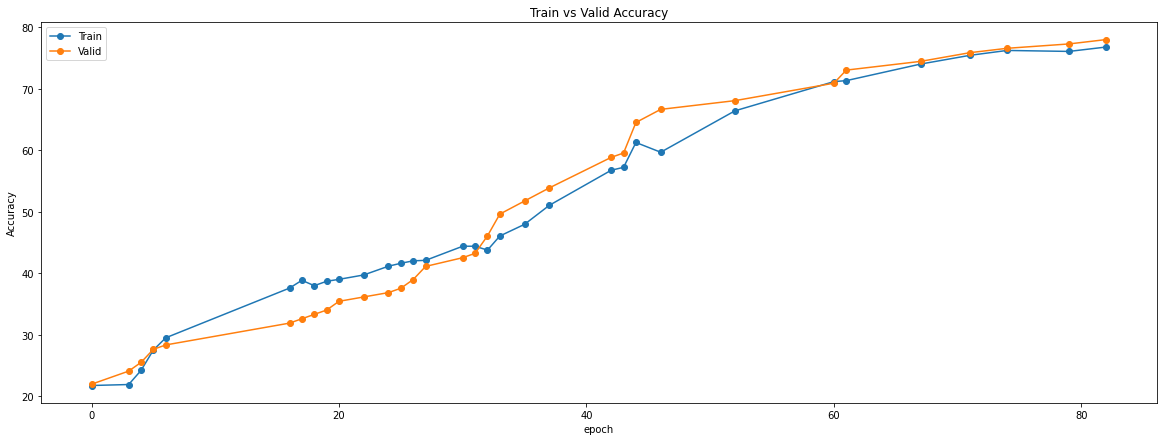

In [15]:
graph(loss_acc_plot,'train_acc', 'val_acc','Accuracy','Accuracy')

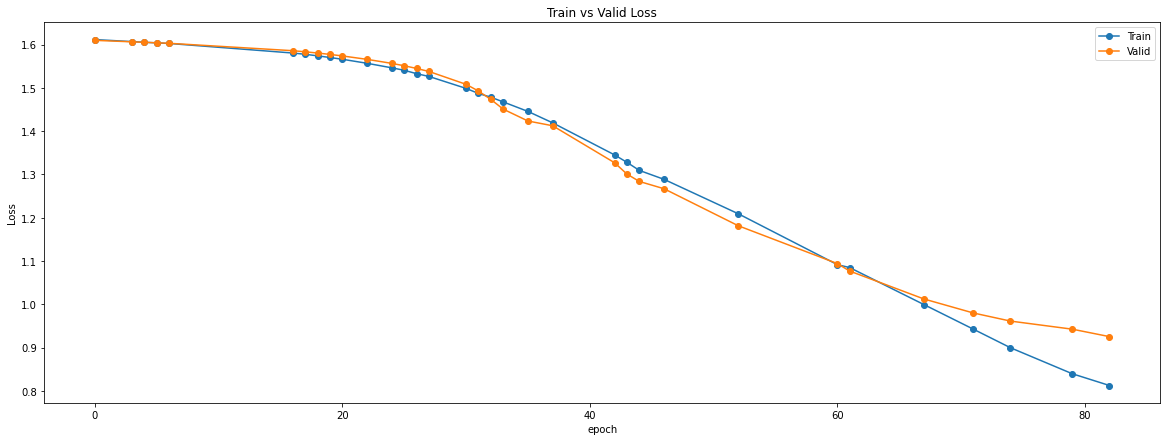

In [16]:
graph(loss_acc_plot, 'train_loss', 'val_loss','Loss','Loss')

In [17]:
checkpoint = torch.load("RNNGlove.h5")
classifier.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
classifier.eval()

args.device = torch.device("cpu")

classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)
loss_func = nn.CrossEntropyLoss(dataset.class_weights)

dataset.set_split('test')

batch_generator = generate_batches(dataset, batch_size=len(dataset), device=args.device)
running_loss = 0.
running_acc = 0.

classifier.eval()
for batch_index, batch_dict in enumerate(batch_generator):
    # compute the output
    y_pred =  classifier(batch_dict['x_data'], x_lengths=batch_dict['x_length'])
    y_actual = batch_dict['y_target']
    
    # compute the loss
    loss = loss_func(y_pred, batch_dict['y_target'])
    loss_t = loss.item()
    running_loss += (loss_t - running_loss) / (batch_index + 1)

    # compute the accuracy
    acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
    running_acc += (acc_t - running_acc) / (batch_index + 1)

train_state['test_loss'] = running_loss
train_state['test_acc'] = running_acc
print("Test loss: {};".format(train_state['test_loss']))
print("Test Accuracy: {}".format(train_state['test_acc']))

Test loss: 1.2309035062789917;
Test Accuracy: 70.37037037037037


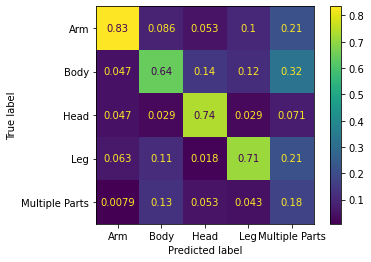

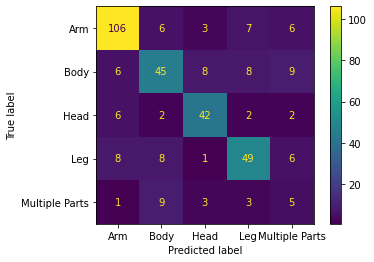

In [18]:
evaulate_performance(y_pred, y_actual, vectorizer)

The confusion matrix above returns the performance of the Vanilla RNN. From the confusion matrix, we can state the following observations:
- The diagonal from the top left to the bottom right represent the true positives. From observation, the model seems to be performing relatively well. Other than the category **Multiple Parts** all other categories have a accuracy rate above 50%. 
- The **leg** and **Arm** categories have the lowest misclassification rate with 71% and 83% accuracy rate, rectrosepctively. 
- Only 18% of the **Multiple Parts** instances have been correctly by the classifier. 

## LSTM

In [19]:
class LstmRNN(nn.Module):
    def __init__(self, input_size, hidden_size, batch_first=True):
        super(LstmRNN, self).__init__()
        
        self.lstm = nn.LSTM(input_size, hidden_size,num_layers=1, batch_first=batch_first) 
        self.hidden_size = hidden_size
        self.batch_first = batch_first
        
    def forward(self, x):
        if self.batch_first:
            batch_first_output, (self.hidden, self.cell) = self.lstm(x)
        else:
            batch_first_output, (self.hidden, self.cell) = self.lstm(x)
        return batch_first_output[:, -1]

In [20]:
classifier = IBPClassifier(
    embedding_size=embedding_size, 
    num_embeddings=len(vectorizer.NARRATIVE_vocab),
    num_classes=len(vectorizer.target_vocab),
    rnn_hidden_size=256,
    hidden_dim = [128, 64],
    RNN=False,
    padding_idx=vectorizer.NARRATIVE_vocab.mask_index,
    pretrained_embeddings=embeddings
)
args.device = torch.device("cuda" if args.cuda else "cpu")
set_seed_everywhere(args.seed, args.cuda)

In [21]:
classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)
loss_func = nn.CrossEntropyLoss(weight=dataset.class_weights)
optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate)
train_state = make_train_state(args)

best_val  = {
    'epoch': 0,
    'model_state_dict': 0,
    'optimizer_state_dict': 0,
    'loss': 0,
    'acc':0
}
lstm_loss_acc_plot = plot_graph(args)
try:
    for epoch_index in range(args.num_epoch):
        train_state['epoch_index'] = epoch_index

        # Iterate over training dataset
        # setup: batch generator, set loss and acc to 0, set train mode on
        dataset.set_split('train')
        batch_generator = generate_batches(dataset, batch_size=len(dataset), device=args.device)
        running_loss = 0.0
        running_acc = 0.0
        classifier.train()

        for batch_index, batch_dict in enumerate(batch_generator):
            # the training routine is these 5 steps:

            # --------------------------------------    
            # step 1. zero the gradients
            optimizer.zero_grad()

            # step 2. compute the output
            y_pred = classifier(x=batch_dict['x_data'], x_lengths=batch_dict['x_length'])

            # step 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_target'])
    
            running_loss += (loss.item() - running_loss) / (batch_index + 1)

            # step 4. use loss to produce gradients
            loss.backward()

            # step 5. use optimizer to take gradient step
            optimizer.step()
            # -----------------------------------------
            # compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)

        train_state['train_loss'].append(running_loss)
        train_state['train_acc'].append(running_acc)

        # Iterate over val dataset\
        # setup: batch generator, set loss and acc to 0; set eval mode on

        dataset.set_split('val')
        batch_generator = generate_batches(dataset, batch_size=len(dataset), device=args.device)
        running_loss = 0.
        running_acc = 0.
        classifier.eval()

        for batch_index, batch_dict in enumerate(batch_generator):
            # compute the output
            y_pred = classifier(x=batch_dict['x_data'], x_lengths=batch_dict['x_length'])

            # step 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_target'])
            running_loss += (loss.item() - running_loss) / (batch_index + 1)

            # compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)

        train_state['val_loss'].append(running_loss)
        train_state['val_acc'].append(running_acc)
        if(best_val['acc']<train_state['val_acc'][-1]):
            best_val  = {
                'epoch': epoch_index,
                'model_state_dict': classifier.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': running_loss,
                'acc': running_acc,
            }
            pretty_print(epoch_index, train_state['train_loss'][-1], train_state['train_acc'][-1], train_state['val_loss'][-1], train_state['val_acc'][-1])
            lstm_loss_acc_plot['epoch_index'].append(epoch_index)
            lstm_loss_acc_plot['val_loss'].append(round(train_state['val_loss'][-1], 4))
            lstm_loss_acc_plot['val_acc'].append(round(train_state['val_acc'][-1], 4))
            lstm_loss_acc_plot['train_loss'].append(round(train_state['train_loss'][-1], 4))
            lstm_loss_acc_plot['train_acc'].append(round(train_state['train_acc'][-1], 4))
        train_state = update_train_state(args=args, model=classifier, train_state=train_state)

except KeyboardInterrupt:
    print("Exiting loop")
torch.save(best_val, "LSTMGlove.h5")

Epochs: 000 | Train loss 1.6126 Train acc 20.506 Val loss 1.6124 Val acc 20.567
Epochs: 027 | Train loss 1.5878 Train acc 21.852 Val loss 1.5862 Val acc 21.985
Epochs: 028 | Train loss 1.5849 Train acc 24.544 Val loss 1.5833 Val acc 24.822
Epochs: 029 | Train loss 1.5816 Train acc 26.840 Val loss 1.5798 Val acc 26.950
Epochs: 030 | Train loss 1.5784 Train acc 27.157 Val loss 1.5759 Val acc 28.368
Epochs: 032 | Train loss 1.5699 Train acc 30.878 Val loss 1.5656 Val acc 29.078
Epochs: 033 | Train loss 1.5642 Train acc 32.066 Val loss 1.5589 Val acc 31.205
Epochs: 035 | Train loss 1.5497 Train acc 34.125 Val loss 1.5411 Val acc 36.879
Epochs: 036 | Train loss 1.5402 Train acc 38.163 Val loss 1.5290 Val acc 42.553
Epochs: 037 | Train loss 1.5285 Train acc 43.151 Val loss 1.5139 Val acc 49.645
Epochs: 038 | Train loss 1.5142 Train acc 48.456 Val loss 1.4953 Val acc 56.028
Epochs: 039 | Train loss 1.4984 Train acc 52.969 Val loss 1.4734 Val acc 58.865
Epochs: 040 | Train loss 1.4795 Train ac

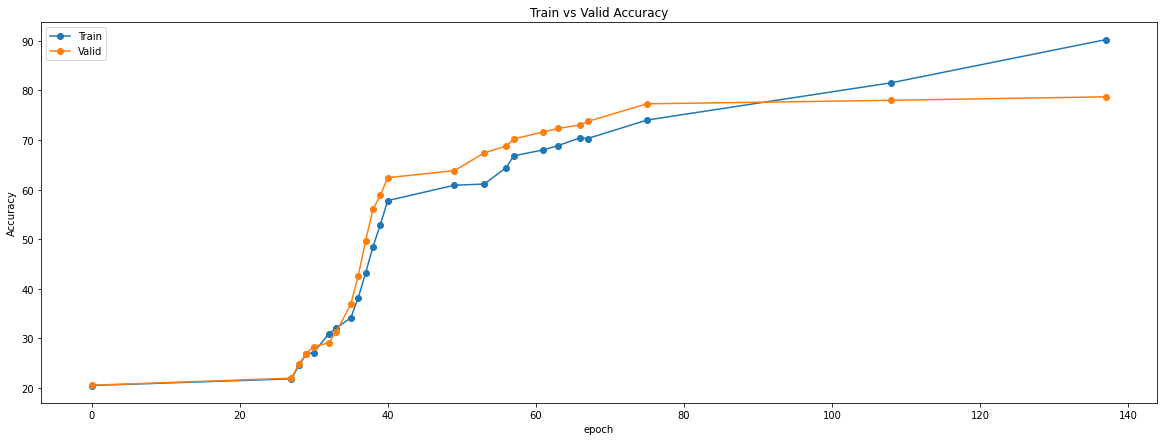

In [22]:
graph(lstm_loss_acc_plot,'train_acc', 'val_acc','Accuracy','Accuracy')

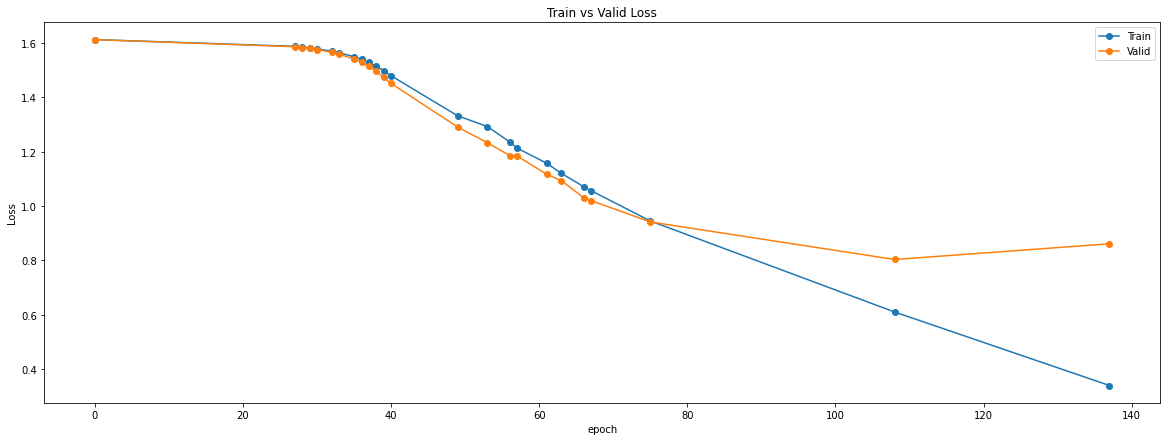

In [23]:
graph(lstm_loss_acc_plot, 'train_loss', 'val_loss','Loss','Loss')

The models seems to be overfitting, hence it may impact the models performance. 

In [24]:
checkpoint = torch.load("LSTMGlove.h5")
classifier.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
classifier.eval()

args.device = torch.device("cpu")

classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)
loss_func = nn.CrossEntropyLoss(dataset.class_weights)

dataset.set_split('test')

batch_generator = generate_batches(dataset, batch_size=len(dataset), device=args.device)
running_loss = 0.
running_acc = 0.

classifier.eval()
for batch_index, batch_dict in enumerate(batch_generator):
    # compute the output
    y_pred =  classifier(batch_dict['x_data'], x_lengths=batch_dict['x_length'])
    y_actual = batch_dict['y_target']
    
    # compute the loss
    loss = loss_func(y_pred, batch_dict['y_target'])
    loss_t = loss.item()
    running_loss += (loss_t - running_loss) / (batch_index + 1)

    # compute the accuracy
    acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
    running_acc += (acc_t - running_acc) / (batch_index + 1)

train_state['test_loss'] = running_loss
train_state['test_acc'] = running_acc
print("Test loss: {};".format(train_state['test_loss']))
print("Test Accuracy: {}".format(train_state['test_acc']))

Test loss: 1.270143985748291;
Test Accuracy: 71.50997150997152


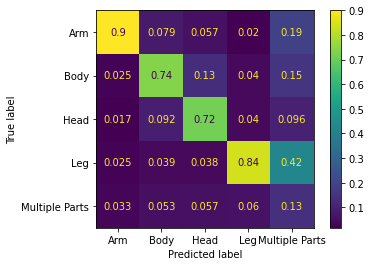

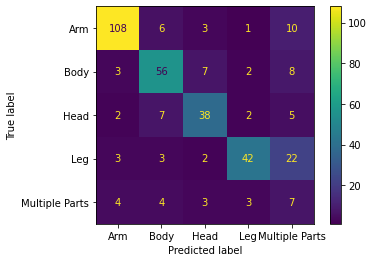

In [25]:
evaulate_performance(y_pred, y_actual, vectorizer)

The confusion matrix above returns the performance of the Vanilla RNN. From the confusion matrix, we can state the following observations:
- The diagonal from the top left to the bottom right represent the true positives. From observation, the model seems to be performing relatively well. Other than the category **Multiple Parts** all other categories have a accuracy rate above 70%. 
- Low percentage (only 13%) of the categories Multiple Parts has ben correctly identified. The **Arm** category peforms the best with 90% accuracy rate (108 instances correctly identified). 

## Overview

In [34]:
data = {'Train Loss':[0.8123 ,0.3399],
        'Train Acc':[76.801,90.261],
       'Val Loss':[0.9252,0.8613 ],
       'Val Acc':[78.014,78.723],
       'Test loss':[1.2309,1.2701],
       'Test Accuracy':[70.3704,71.5099]}

df = pd.DataFrame(data, index=['Vanilla RNN','LSTM'])
df

,Train Loss,Train Acc,Val Loss,Val Acc,Test loss,Test Accuracy
Vanilla RNN,0.8123,76.801,0.9252,78.014,1.2309,70.3704
LSTM,0.3399,90.261,0.8613,78.723,1.2701,71.5099


From the Test Accuracy, we can see that the LSTM performs slightly better than the Vanilla RNN model. Referencing from the LSTM training and validation loss, the model may potentially be overfitting the data hence resulting in a higher test loss score. In terms of accuracy, the LSTM performs better. 

#### Confusion Matrix
- The confusion matrix of the two model tells a different story. If we look at the two matrics, you will notice that the matrix for the LSTM model perform much better than for RNN. 
- In both models, the categories **Arm, Body, Head** produce the high accuracy rate with **Arm** in lead with 90% for the lstm model and 83% for the vanilla RNN model. 
- In both models, the category **Multiple Parts** perform the worst. There is a noticable difference for this particular category, as for the RNN model, 18% of the instances are correctly identified, and relatively lower for the RNN at 13%. 
- There is a severe improvement for the **Leg** categories as there is a massive jump from 71% to 84% of correcntly idenfitied instances, from the RNN to LSRM model, rectrosepctively. 
- Overvall, there is only small improvements in terms of the classificaiton rate (the performance) for the LSTM over the Vanilla RNN. 

## Bonus | GRU

In [27]:
class GruRNN(nn.Module):
    def __init__(self, input_size, hidden_size, batch_first=True):
        super(GruRNN, self).__init__()
        
        self.lstm = nn.GRU(input_size, hidden_size,num_layers=1, batch_first=batch_first) 
        self.hidden_size = hidden_size
        self.batch_first = batch_first
        
    def forward(self, x):
        if self.batch_first:
            batch_first_output, self.hidden = self.lstm(x)
        else:
            batch_first_output, self.hidden = self.lstm(x)
        return batch_first_output[:, -1]

In [28]:
class GRU_Model(nn.Module):
    def __init__(self, embedding_size, num_embeddings, num_classes, rnn_hidden_size, hidden_dim, RNN=True, pretrained_embeddings=None, padding_idx=0, batch_first=True):
        super(GRU_Model, self).__init__()

        self.emb = nn.Embedding(embedding_dim=embedding_size, num_embeddings=num_embeddings, padding_idx=padding_idx) 

        self.rnn = GruRNN(input_size=embedding_size, hidden_size=rnn_hidden_size, batch_first=batch_first)

        
        self.RNN = RNN
        self.num_classes = num_classes
        self.rnn_hidden_size = rnn_hidden_size
        #MLP         
        self.fc1 = nn.Linear(rnn_hidden_size, hidden_dim[0])
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.1)

        self.fc2 = nn.Linear(hidden_dim[0], hidden_dim[1])
        self.relu2 = nn.ReLU()

        self.fc3 = nn.Linear(hidden_dim[1], num_classes)

    def forward(self, x, x_lengths=None, apply_softmax=False):
        # embed and permute so features are channels
        out = self.emb(x)
        out = self.rnn(out)

        
        if self.RNN:
            if x_lengths is not None:
                out = column_gather(out, x_lengths)
            else:
                out = out[:, -1, :]

        out = self.fc1(out)
        out = self.relu1(out)
        out = self.dropout1(out)
        
        out = self.fc2(out)
        out = self.relu2(out)
        
        out = self.fc3(out)

        if apply_softmax:
            out = torch.nn.functional.softmax(out, dim=1)

        return out

In [29]:
classifier = GRU_Model(
    embedding_size=embedding_size, 
    num_embeddings=len(vectorizer.NARRATIVE_vocab),
    num_classes=len(vectorizer.target_vocab),
    rnn_hidden_size=256,
    hidden_dim = [128, 64],
    padding_idx=vectorizer.NARRATIVE_vocab.mask_index,
    pretrained_embeddings=embeddings,
    RNN=False
)
args.device = torch.device("cuda" if args.cuda else "cpu")
set_seed_everywhere(args.seed, args.cuda)

In [30]:
classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)
    
loss_func = nn.CrossEntropyLoss(weight=dataset.class_weights)
optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate)

train_state = make_train_state(args)

best_val  = {
    'epoch': 0,
    'model_state_dict': 0,
    'optimizer_state_dict': 0,
    'loss': 0,
    'acc':0
}

try:
    for epoch_index in range(args.num_epoch):
        train_state['epoch_index'] = epoch_index

        # Iterate over training dataset
        # setup: batch generator, set loss and acc to 0, set train mode on
        dataset.set_split('train')
        batch_generator = generate_batches(dataset, batch_size=len(dataset), device=args.device)
        running_loss = 0.0
        running_acc = 0.0
        classifier.train()

        for batch_index, batch_dict in enumerate(batch_generator):
            # the training routine is these 5 steps:

            # --------------------------------------    
            # step 1. zero the gradients
            optimizer.zero_grad()

            # step 2. compute the output
            y_pred = classifier(x=batch_dict['x_data'], x_lengths=batch_dict['x_length'])

            # step 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_target'])
    
            running_loss += (loss.item() - running_loss) / (batch_index + 1)

            # step 4. use loss to produce gradients
            loss.backward()

            # step 5. use optimizer to take gradient step
            optimizer.step()
            # -----------------------------------------
            # compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)

        train_state['train_loss'].append(running_loss)
        train_state['train_acc'].append(running_acc)

        # Iterate over val dataset\
        # setup: batch generator, set loss and acc to 0; set eval mode on

        dataset.set_split('val')
        batch_generator = generate_batches(dataset, batch_size=len(dataset), device=args.device)
        running_loss = 0.
        running_acc = 0.
        classifier.eval()

        for batch_index, batch_dict in enumerate(batch_generator):
            # compute the output
            y_pred = classifier(x=batch_dict['x_data'], x_lengths=batch_dict['x_length'])

            # step 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_target'])
            running_loss += (loss.item() - running_loss) / (batch_index + 1)

            # compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)

        train_state['val_loss'].append(running_loss)
        train_state['val_acc'].append(running_acc)
        if(best_val['acc']<train_state['val_acc'][-1]):
            best_val  = {
                'epoch': epoch_index,
                'model_state_dict': classifier.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': running_loss,
                'acc': running_acc,
            }
            pretty_print(epoch_index, train_state['train_loss'][-1], train_state['train_acc'][-1], train_state['val_loss'][-1], train_state['val_acc'][-1])
            
        train_state = update_train_state(args=args, model=classifier, train_state=train_state)

except KeyboardInterrupt:
    print("Exiting loop")
torch.save(best_val, "GRUGlove.h5")

Epochs: 000 | Train loss 1.6117 Train acc 16.389 Val loss 1.6091 Val acc 21.985
Epochs: 003 | Train loss 1.6076 Train acc 21.536 Val loss 1.6050 Val acc 22.695
Epochs: 004 | Train loss 1.6063 Train acc 21.773 Val loss 1.6037 Val acc 24.113
Epochs: 005 | Train loss 1.6045 Train acc 20.902 Val loss 1.6024 Val acc 25.531
Epochs: 006 | Train loss 1.6030 Train acc 22.723 Val loss 1.6012 Val acc 29.078
Epochs: 009 | Train loss 1.5985 Train acc 28.107 Val loss 1.5967 Val acc 29.787
Epochs: 012 | Train loss 1.5931 Train acc 32.304 Val loss 1.5910 Val acc 32.624
Epochs: 013 | Train loss 1.5910 Train acc 34.283 Val loss 1.5889 Val acc 35.460
Epochs: 014 | Train loss 1.5881 Train acc 34.204 Val loss 1.5865 Val acc 36.170
Epochs: 016 | Train loss 1.5837 Train acc 36.896 Val loss 1.5812 Val acc 39.007
Epochs: 017 | Train loss 1.5799 Train acc 38.796 Val loss 1.5782 Val acc 41.843
Epochs: 019 | Train loss 1.5730 Train acc 41.488 Val loss 1.5717 Val acc 43.971
Epochs: 020 | Train loss 1.5701 Train ac

In [31]:
args.device = torch.device("cpu")
checkpoint = torch.load("GRUGlove.h5")
classifier.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
classifier.eval()

classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)
loss_func = nn.CrossEntropyLoss(dataset.class_weights)

dataset.set_split('test')

batch_generator = generate_batches(dataset, batch_size=len(dataset), device=args.device)
running_loss = 0.
running_acc = 0.

classifier.eval()
for batch_index, batch_dict in enumerate(batch_generator):
    # compute the output
    y_pred =  classifier(batch_dict['x_data'], x_lengths=batch_dict['x_length'])
    y_actual = batch_dict['y_target']
    
    # compute the loss
    loss = loss_func(y_pred, batch_dict['y_target'])
    loss_t = loss.item()
    running_loss += (loss_t - running_loss) / (batch_index + 1)

    # compute the accuracy
    acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
    running_acc += (acc_t - running_acc) / (batch_index + 1)

train_state['test_loss'] = running_loss
train_state['test_acc'] = running_acc
print("Test loss: {};".format(train_state['test_loss']))
print("Test Accuracy: {}".format(train_state['test_acc']))

Test loss: 1.6799514293670654;
Test Accuracy: 76.63817663817663


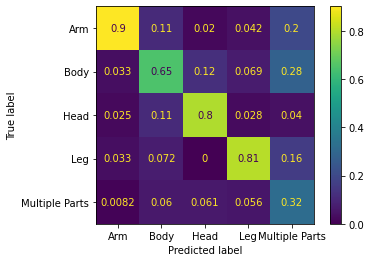

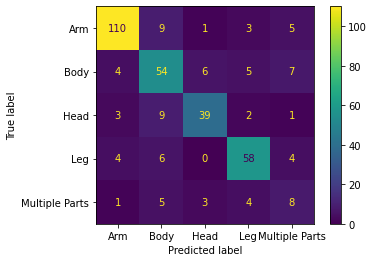

In [32]:
evaulate_performance(y_pred, y_actual, vectorizer)

Add a 

In [33]:
vectorizer.target_vocab.lookup_index(0), vectorizer.target_vocab.lookup_index(1), vectorizer.target_vocab.lookup_index(2), vectorizer.target_vocab.lookup_index(3), vectorizer.target_vocab.lookup_index(4)

('Arm', 'Body', 'Head', 'Leg', 'Multiple Parts')

# Conclustion

We can see the model performance of `LSTM` performance is lower than Basic `RNN` and `GRN`

As shown in the table below, GRU has a test accuracy of 76.64% with a test loss of 1.68. I believe out of the three models, depite the high accuracy achieve by the GRU model, the Vanilla RNN produces the best results due to its lower test loss. 

In [36]:
data = {'Train Loss':[0.8123 ,0.3399, 0.0113],
        'Train Acc':[76.801,90.261, 99.920],
       'Val Loss':[0.9252,0.8613, 1.6721 ],
       'Val Acc':[78.014,78.723,81.560 ],
       'Test loss':[1.2309,1.2701, 1.6800],
       'Test Accuracy':[70.3704,71.5099,76.6382 ]}

df = pd.DataFrame(data, index=['Vanilla RNN','LSTM', 'GRU'])
df

,Train Loss,Train Acc,Val Loss,Val Acc,Test loss,Test Accuracy
Vanilla RNN,0.8123,76.801,0.9252,78.014,1.2309,70.3704
LSTM,0.3399,90.261,0.8613,78.723,1.2701,71.5099
GRU,0.0113,99.920,1.6721,81.560,1.6800,76.6382
